# Naive Bayes Classification
Naive Bayes is one of the most common ML algorithms used for text classification purposes.


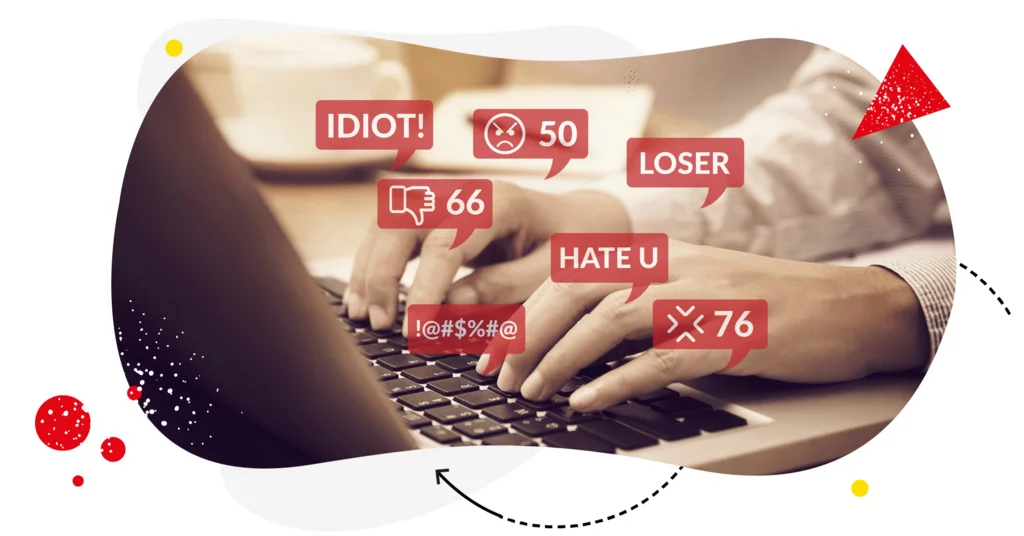

Here's the checked version with some corrections and improvements:

"My sister is working as a chat support in a BPO company, where she handles a certain product and is in charge of maintaining its social media comments and reviews. I will take this opportunity to demonstrate how Naive Bayes classification works with text files.

In this project, we will predict whether a certain message is 'good' or 'bad.' While we can predict it manually for a small number of messages, let's consider the scenario with 100, 1000, or even 5000 messages per day. Handling such a volume manually would be challenging, necessitating additional manpower.

Instead of reading thousands of messages, comments, reviews, or tweets about the product, we can utilize the Naive Bayes classifier to instantly determine how many are positive and how many are negative.

To do this, we need to train a model. Technically, this involves counting every word in each category (positive and negative). Let's assume that we are given a training dataset that looks something like the example below."

To do this, we will first need to train a model. Technicaly counting every words in each category (positive and negative). 
Let's assume that we are given a training dataset which looks like something below. 

### Training Samples

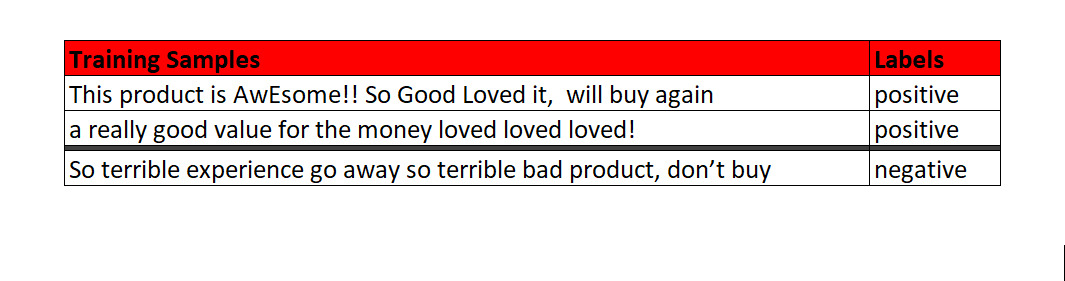

### Prior Probability
Probability of being Positive and Negative.

In [ ]:
# positive label = 2
# negative label = 1
# total training sample = 3

# since we have a very small training sample lets plug in values directly
# prior probability of positive label
p_p = 2/3

# prior probability of negative label
p_n = 1/3
print(p_p)
print(p_n)

### Bag of Words
Count of appearance of each words per label(Positive / Negative).

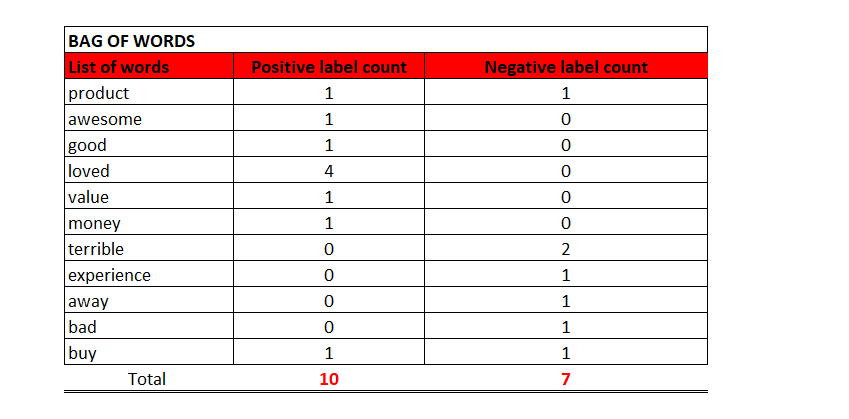

### Test Sample Comment
Comments will be cleaned, convert to lowercase, remove unnecessary, word and punctuations.
- 'buy it!, loved it ;)' --> `buy loved`


Notice that our formula from above table doesnt fit the equation below. Thats because we add extra 1 count to every words to avoid zero probability.

In [ ]:
# Note: we add 1 to every words 

# probability of 'buy' given 'positive'...
# p(buy|positive)
p_buy_positive = 2/21
# probability of 'loved' given 'positive'...
p_loved_positive = 5/21
#
# probability for negative
p_buy_negative = 2/18
p_loved_negative = 1/18

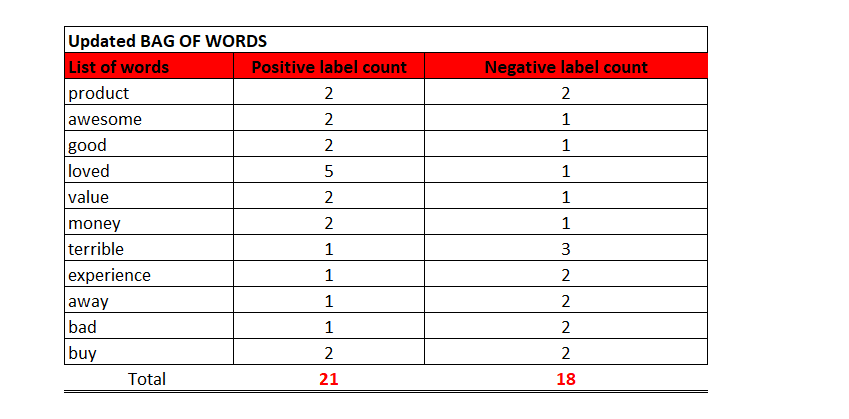

### Probabilities of Positive Given 'buy loved'

In [ ]:
# plug in values
# p(positive| buy loved)
p_positive_buy_loved = p_p * p_buy_positive * p_loved_positive
p_positive_buy_loved

### Probability of being negative Given 'buy loved'

In [ ]:
# p(negative| buy loved)
p_negative_buy_loved = p_n * p_buy_negative * p_loved_negative
p_negative_buy_loved

Since we got higher probability of being positive, our test sample `buy it!, loved it ;)` is a positive.

#### What if we got some words in our that doesnt exist yet in our bag of words?

Test sample2 = `stupid product!` 


- That new words need to be labeled first as positive or negative then put that in our `bags of words` for future reference.Let say the word `stupid` labeled as negative.

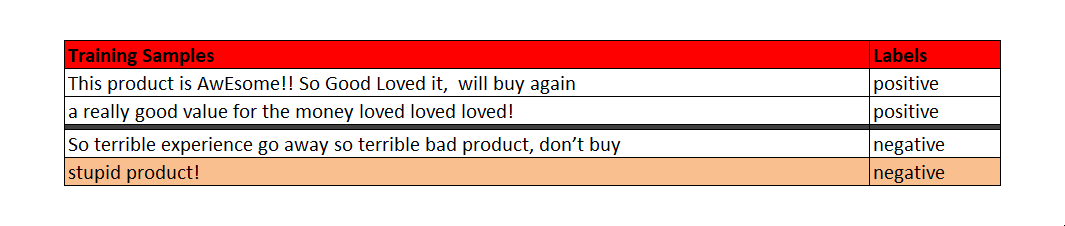
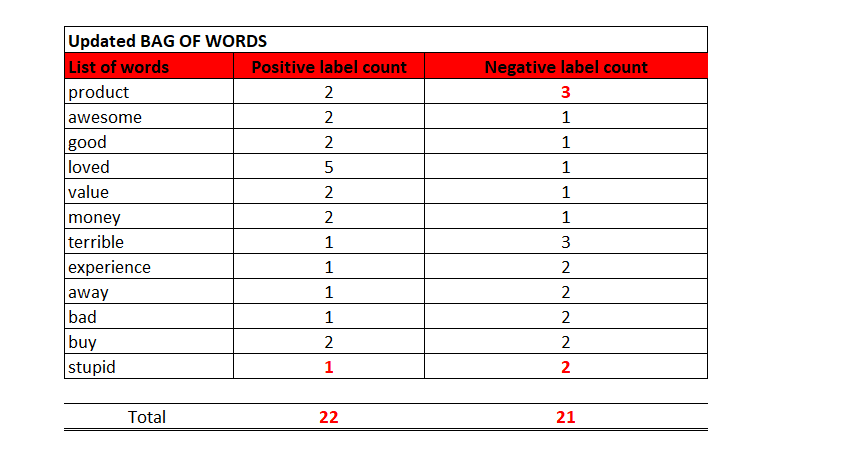

#### p (positve | stupid product)

In [ ]:
p_stupid_positive = 1/22
p_product_positive = 2/22
#
# probability of positive given stupid product
# 2/4 is the updated probability of positive p(P)
p_positive_stupid_product = (2/4) * p_stupid_positive * p_product_positive
p_positive_stupid_product

#### p (negative | stupid product)

In [ ]:
p_stupid_negative = 2/21
p_product_negative = 3/21
p_negative_stupid_product = (2/4) * p_stupid_negative * p_product_negative
p_negative_stupid_product

Our model correctly labeled our new sample as negative. 

# Sklean Implementation

First we will do the Naive Bayes classification by our class/function then after that we will use the SKlean MultinomialNB.

In [1]:
import pandas as pd 
import numpy as np 
from collections import defaultdict
import re
from sklearn.naive_bayes import MultinomialNB 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

###  Creating Class and Functions

In [72]:
class NaiveBayes:
    
    def __init__(self,unique_classes):
        
        self.classes=unique_classes # Constructor is sinply passed with unique number of classes of the training set
        

    def addToBow(self,example,dict_index):
        
        '''
            Parameters:
            1. example 
            2. dict_index - implies to which BoW category this example belongs to
            What the function does?
            -----------------------
            It simply splits the example on the basis of space as a tokenizer and adds every tokenized word to
            its corresponding dictionary/BoW
            Returns:
            ---------
            Nothing
        
       '''
        
        if isinstance(example,np.ndarray): example=example[0]
     
        for token_word in example.split(): #for every word in preprocessed example
          
            self.bow_dicts[dict_index][token_word]+=1 #increment in its count
            
    def train(self,dataset,labels):
        
        '''
            Parameters:
            1. dataset - shape = (m X d)
            2. labels - shape = (m,)
            What the function does?
            -----------------------
            This is the training function which will train the Naive Bayes Model i.e compute a BoW for each
            category/class. 
            Returns:
            ---------
            Nothing
        
        '''
    
        self.examples=dataset
        self.labels=labels
        self.bow_dicts=np.array([defaultdict(lambda:0) for index in range(self.classes.shape[0])])
        
        #only convert to numpy arrays if initially not passed as numpy arrays - else its a useless recomputation
        
        if not isinstance(self.examples,np.ndarray): self.examples=np.array(self.examples)
        if not isinstance(self.labels,np.ndarray): self.labels=np.array(self.labels)
            
        #constructing BoW for each category
        for cat_index,cat in enumerate(self.classes):
          
            all_cat_examples=self.examples[self.labels==cat] #filter all examples of category == cat
            
            #get examples preprocessed
            
            cleaned_examples=[preprocess_string(cat_example) for cat_example in all_cat_examples]
            
            cleaned_examples=pd.DataFrame(data=cleaned_examples)
            
            #now costruct BoW of this particular category
            np.apply_along_axis(self.addToBow,1,cleaned_examples,cat_index)
            
                
        ###################################################################################################
        
        '''
            Although we are done with the training of Naive Bayes Model BUT!!!!!!
            ------------------------------------------------------------------------------------
            Remember The Test Time Forumla ? : {for each word w [ count(w|c)+1 ] / [ count(c) + |V| + 1 ] } * p(c)
            ------------------------------------------------------------------------------------
            
            We are done with constructing of BoW for each category. But we need to precompute a few 
            other calculations at training time too:
            1. prior probability of each class - p(c)
            2. vocabulary |V| 
            3. denominator value of each class - [ count(c) + |V| + 1 ] 
            
            Reason for doing this precomputing calculations stuff ???
            ---------------------
            We can do all these 3 calculations at test time too BUT doing so means to re-compute these 
            again and again every time the test function will be called - this would significantly
            increase the computation time especially when we have a lot of test examples to classify!!!).  
            And moreover, it doensot make sense to repeatedly compute the same thing - 
            why do extra computations ???
            So we will precompute all of them & use them during test time to speed up predictions.
            
        '''
        
        ###################################################################################################
      
        prob_classes=np.empty(self.classes.shape[0])
        all_words=[]
        cat_word_counts=np.empty(self.classes.shape[0])
        for cat_index,cat in enumerate(self.classes):
           
            #Calculating prior probability p(c) for each class
            prob_classes[cat_index]=np.sum(self.labels==cat)/float(self.labels.shape[0]) 
            
            #Calculating total counts of all the words of each class 
            count=list(self.bow_dicts[cat_index].values())
            cat_word_counts[cat_index]=np.sum(np.array(list(self.bow_dicts[cat_index].values())))+1 # |v| is remaining to be added
            
            #get all words of this category                                
            all_words+=self.bow_dicts[cat_index].keys()
                                                     
        
        #combine all words of every category & make them unique to get vocabulary -V- of entire training set
        
        self.vocab=np.unique(np.array(all_words))
        self.vocab_length=self.vocab.shape[0]
                                  
        #computing denominator value                                      
        denoms=np.array([cat_word_counts[cat_index]+self.vocab_length+1 for cat_index,cat in enumerate(self.classes)])                                                                          
      
        '''
            Now that we have everything precomputed as well, its better to organize everything in a tuple 
            rather than to have a separate list for every thing.
            
            Every element of self.cats_info has a tuple of values
            Each tuple has a dict at index 0, prior probability at index 1, denominator value at index 2
        '''
        
        self.cats_info=[(self.bow_dicts[cat_index],prob_classes[cat_index],denoms[cat_index]) for cat_index,cat in enumerate(self.classes)]                               
        self.cats_info=np.array(self.cats_info)                                 
                                              
                                              
    def getExampleProb(self,test_example):                                
        
        '''
            Parameters:
            -----------
            1. a single test example 
            What the function does?
            -----------------------
            Function that estimates posterior probability of the given test example
            Returns:
            ---------
            probability of test example in ALL CLASSES
        '''                                      
                                              
        likelihood_prob=np.zeros(self.classes.shape[0]) #to store probability w.r.t each class
        
        #finding probability w.r.t each class of the given test example
        for cat_index,cat in enumerate(self.classes): 
                             
            for test_token in test_example.split(): #split the test example and get p of each test word
                
                ####################################################################################
                                              
                #This loop computes : for each word w [ count(w|c)+1 ] / [ count(c) + |V| + 1 ]                               
                                              
                ####################################################################################                              
                
                #get total count of this test token from it's respective training dict to get numerator value                           
                test_token_counts=self.cats_info[cat_index][0].get(test_token,0)+1
                
                #now get likelihood of this test_token word                              
                test_token_prob=test_token_counts/float(self.cats_info[cat_index][2])                              
                
                #remember why taking log? To prevent underflow!
                likelihood_prob[cat_index]+=np.log(test_token_prob)
                                              
        # we have likelihood estimate of the given example against every class but we need posterior probility
        post_prob=np.empty(self.classes.shape[0])
        for cat_index,cat in enumerate(self.classes):
            post_prob[cat_index]=likelihood_prob[cat_index]+np.log(self.cats_info[cat_index][1])                                  
      
        return post_prob
    
   
    def test(self,test_set):
      
        '''
            Parameters:
            -----------
            1. A complete test set of shape (m,)
            
            What the function does?
            -----------------------
            Determines probability of each test example against all classes and predicts the label
            against which the class probability is maximum
            Returns:
            ---------
            Predictions of test examples - A single prediction against every test example
        '''       
       
        predictions=[] #to store prediction of each test example
        for example in test_set: 
                                              
            #preprocess the test example the same way we did for training set exampels                                  
            cleaned_example=preprocess_string(example) 
             
            #simply get the posterior probability of every example                                  
            post_prob=self.getExampleProb(cleaned_example) #get prob of this example for both classes
            
            #simply pick the max value and map against self.classes!
            predictions.append(self.classes[np.argmax(post_prob)])
                
        return np.array(predictions) 

In [73]:
def preprocess_string(str_arg):
    
    """"
        Parameters:
        ----------
        str_arg: example string to be preprocessed
        
        What the function does?
        -----------------------
        Preprocess the string argument - str_arg - such that :
        1. everything apart from letters is excluded
        2. multiple spaces are replaced by single space
        3. str_arg is converted to lower case 
        
        Example:
        --------
        Input :  Menu is absolutely perfect,loved it!
        Output:  menu is absolutely perfect loved it
        
        Returns:
        ---------
        Preprocessed string 
        
    """
    
    cleaned_str=re.sub('[^a-z\s]+',' ',str_arg,flags=re.IGNORECASE) #every char except alphabets is replaced
    cleaned_str=re.sub('(\s+)',' ',cleaned_str) #multiple spaces are replaced by single space
    cleaned_str=cleaned_str.lower() #converting the cleaned string to lower case
    
    return cleaned_str # returning the preprocessed string 

In [74]:
df = pd.read_csv('nb.csv')
df.head(10)

,training samples,labels
0,This product is awEsome so good loved it will...,positive
1,a really good value for the money loved loved ...,positive
2,So terrible experience go away so terrible bad...,negative
3,Stupid! product hate it very much,negative
4,Very nice,positive
5,Worth of Money,positive
6,Super delicious,positive
7,I want more,positive
8,Do you wanna be a snowman,positive
9,I hate this product,negative


In [75]:
# cleaning data
df['training_clean'] = [preprocess_string(train_str) for train_str in df['training samples']]
df.head(10)

,training samples,labels,training_clean
0,This product is awEsome so good loved it will...,positive,this product is awesome so good loved it will ...
1,a really good value for the money loved loved ...,positive,a really good value for the money loved loved ...
2,So terrible experience go away so terrible bad...,negative,so terrible experience go away so terrible bad...
3,Stupid! product hate it very much,negative,stupid product hate it very much
4,Very nice,positive,very nice
5,Worth of Money,positive,worth of money
6,Super delicious,positive,super delicious
7,I want more,positive,i want more
8,Do you wanna be a snowman,positive,do you wanna be a snowman
9,I hate this product,negative,i hate this product


In [76]:
# define x and y
x = df['training_clean'].values
y = df['labels'].values

In [77]:
# split data
train_data,test_data,train_labels,test_labels = train_test_split(x,y,
                                                                 shuffle=True,
                                                                 test_size=0.2,
                                                                 random_state=42,
                                                                 stratify=y)
labels=np.unique(train_labels)


In [78]:
# naive bayes instance
nb=NaiveBayes(labels)

In [79]:
# train data
# nb.train will also do words cleaning 
nb.train(train_data, train_labels)

### Testing

In [61]:
# prediction of our x_test samples
predict_labels = nb.test(test_data)
print(test_data)
predict_labels

['i hate this product' 'super delicious']


array(['positive', 'positive'], dtype='<U8')

In [62]:
# True value
test_labels

array(['negative', 'positive'], dtype=object)

In [63]:
accuracy = np.sum(predict_labels == test_labels) / float(test_labels.shape[0])
accuracy

0.5

Wow! We got 50% accuracy. haaha, thats because we only have two training data/testing labels

Let's try some random comments:

In [64]:
comment1 = ['perfect for all ages, so good will buy again']
comment2 = ['this is so awesome yeheey']
comment3 = ['bad advertisement annoying']

In [67]:
# Note:
# nb.test will automatically clean our data, remove unnecessary charactes and convert to lowercase.

# comment1
predict_labels = nb.test(comment1)
print(comment1 + list(predict_labels))

# comment2
predict_labels2 = nb.test(comment2)
print(comment2 + list(predict_labels2))

# comment3
predict_labels3 = nb.test(comment3)
print(comment3 + list(predict_labels3))

['perfect for all ages, so good will buy again', 'positive']
['this is so awesome yeheey', 'positive']
['bad advertisement annoying', 'negative']


In [80]:
comment4=['''Stop dating people who cannot afford basic things! Transport fare, mobile data, food and clothes.
          They are not ready for a relationship. I mean, sa totoo lang tayo. This post is not gender specific. 
          Financial stability is part of preparation for a lifelong commitment. Remember, money is the major cause
          of problems for couples. Tama na yung mindset na: “Okay lang, mahal naman namin ang isa’t-isa e”. Sa una,
          baka matiis nyo pa BUT sooner or later magiging problema nyo na yan because you chose someone who is not 
          financially equipped to sustain a relationship.
          If they don't know shit about money and financial literacy, 
          it might cause trouble for the both of you in the future.''']

In [81]:
comment4_predict = nb.test(comment4)
comment4_predict

array(['negative'], dtype='<U8')

Despite of a very limited vocabulary, our model predicted our samples correctly. Now let's do this in a larger dataset. SKlearn has a build-in dataset named `fetch_20newsgroups` and also theres is a [`Bag of words`](https://www.kaggle.com/competitions/word2vec-nlp-tutorial/data) from kaggle. We can use this datasets to train our model for predicting reviews and comments.

# Let's Try in a Bigger Dataset
`Data Soure:` [Kaggle Bag of Words](https://www.kaggle.com/competitions/word2vec-nlp-tutorial/data?select=labeledTrainData.tsv.zip)

Sentiments:
- 0 = Bad
- 1 = Good

In [17]:
df = pd.read_csv('labeledTrainData.tsv',sep='\t')

In [18]:
print(df.shape)
df.head()

(25000, 3)


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [36]:
# Define X and y
y = df.sentiment.values
X = df.review.values

In [37]:
# Split data
train_data,test_data,train_labels,test_labels=train_test_split(X,y,
                                                               shuffle=True,
                                                               test_size=0.25,
                                                               random_state=69,
                                                               stratify=y)
labels = np.unique(train_labels)

In [38]:
# training data
nb = NaiveBayes(labels)

# nb.train will do the words cleaning for us
nb.train(train_data,train_labels)

In [39]:
# Testing
# prediction for test_data (sometime set as x_test)
y_predict = nb.test(test_data)
# prediction vs. true labels (test_labels sometime set as y_test)
accuracy = np.sum(y_predict == test_labels)/float(test_labels.shape[0])
accuracy

0.84032

We got 84% accuracy. Let's test again our comments

In [51]:
comment1_predict = nb.test(comment1)
comment2_predict = nb.test(comment2)
comment3_predict = nb.test(comment3)
print(comment1 + list(comment1_predict))
print(comment2 + list(comment2_predict))
print(comment3 + list(comment3_predict))

['perfect for all ages, so good will buy again', 1]
['this is so awesome yeheey', 1]
['bad advertisement annoying', 0]


# Using Sklearn 

#### Define X and y

In [24]:
y = df.sentiment.values
X = df.review.values

#### Cleaning data

In [25]:
X =[preprocess_string(train_str) for train_str in X]

#uncomment to view sample of cleaned reviews 
# X[0]

#### Split data

In [26]:
train_data,test_data,train_labels,test_labels=train_test_split(X,y,
                                                               shuffle=True,
                                                               test_size=0.25,
                                                               random_state=69,
                                                               stratify=y)

### Tranforming the train and test data to a MultinomialNB readable format.
#### Train data

In [27]:
# instantiate it's object
count_vect = CountVectorizer()

In [28]:
# do the computation then transform to a Naive Bayes readable format
train_data_counter = count_vect.fit_transform(train_data) 

#### Test data

In [29]:
# transforms only 'NOT FIT_TRANSFORM'
# we are doing the computation on the training data thus that will be using by our model learn,
# testing data are used for evaluation only but need to transform to the same format.
test_data_counter = count_vect.transform(test_data) 

#### MultinomialNB

In [30]:
# simply instantiate a Multinomial Naive Bayes object
clf = MultinomialNB() 

In [31]:
#calling the fit method to train the train_data_counter and train_labels
clf.fit(train_data_counter, train_labels) 

MultinomialNB()

#### Evaluation

In [32]:
# using the test_data_counter (transformed test_data to a clf readable format)
y_predict = clf.predict(test_data_counter) 

In [33]:
y_predict

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [34]:
# Different scoring code, same result
print(clf.score(test_data_counter, test_labels))
print (np.sum(y_predict == test_labels)/float(len(test_labels))) 

0.84608
0.84608


#### Testing

In [35]:
# Tranform first our comments, assuming that comments are already cleaned
c1 = count_vect.transform(comment1) 
c2 = count_vect.transform(comment2) 
c3 = count_vect.transform(comment3) 
print(comment1 + list(clf.predict(c1)))
print(comment2 + list(clf.predict(c2)))
print(comment3 + list(clf.predict(c3)))

['perfect for all ages, so good will buy again', 1]
['this is so awesome yeheey', 1]
['bad advertisement annoying', 0]


- fin